In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from sharedcontrolpaper.utils import get_subject_label, string_to_numbers, process_trial_data, plot_trial_pressure_individual

In [2]:
parent_directory = os.path.dirname(os.getcwd())
data_path = os.path.join(parent_directory, 'data', 'experiment')
task = "shared_control"
exp_stage = "final"
pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
data_files = glob.glob(pattern)

In [3]:
shared_control_metrics = {}

for file in data_files:
    subject_label = get_subject_label(file)
    
    df = pd.read_csv(file)
    
    # some post processing
    df['phase_raw'] = df['phase_raw'].str.strip("'")
    df['block_raw'] = df['block_raw'].str.strip("'")
    
    df_test = df.query("phase_raw == 'test'")
    block_1 = df_test.query("block_raw == 'block 1'")
    block_2 = df_test.query("block_raw == 'block 2'")
    block_1 = block_1.reset_index(drop=True)
    block_2 = block_2.reset_index(drop=True)

    task_dfs = [block_1, block_2]
    
    for df in task_dfs:
        if 'ai' in df['condition'].values:
            ai_data = df.copy()
            ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
            ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
            ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
        else:
            control_data = df.copy()
            control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
            control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
            control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)
    
    shared_control_metrics[subject_label] = {'ai': {'data': ai_data}, 'non_ai': {'data': control_data}}
    
    for block in shared_control_metrics[subject_label].keys():
        trial_results, ssrt_list = process_trial_data(shared_control_metrics[subject_label][block]['data'], block=block)
        shared_control_metrics[subject_label][block]['trial_results'] = trial_results
        shared_control_metrics[subject_label][block]['ssrt_list'] = ssrt_list 


In [4]:
%store shared_control_metrics

Stored 'shared_control_metrics' (dict)


## Excluded Observations

In [5]:
exclusions = {"s027": ["ai", 80, 96]}

## Grabbing SSRT and other metrics across conditions

In [6]:
def grab_mean_metric(measure):

    """
    Function to find the mean of a specified metric across different trial conditions 
    for each subject. The provided measure should be a string representing the metric 
    to analyze (e.g., 'ssrt' or 'duration_of_inhibition'). The results are saved to a 
    CSV file with each row corresponding to a subject, with columns for the means 
    of the measure in each of the three trial conditions.

    Parameters:
    - measure (str): The name of the measure to calculate the mean for.

    Outputs:
    - Saves a CSV file with means for each subject across non_ai trials, ai_condition_stop_trials, 
      and ai_condition_ai_trials, as well as handling specific conditions based on the flag.
    """

    condition_measure = {}

    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []
        
        for block in shared_control_metrics[subject].keys():
            
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():

                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
        

                if block == 'non_ai':
                    non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    

        avg_ai_ai = np.nanmean(ai_condition_ai_trials)
        avg_ai = np.nanmean(ai_condition_stop_trials)
        avg_non_ai = np.nanmean(non_ai_condition_stop_trials)
        
        condition_measure[subject] = {f'non_ai': avg_non_ai, f'ai': avg_ai, f'ai_ai': avg_ai_ai}

    df = pd.DataFrame(condition_measure).T
    df = df.sort_index()
    df.loc['mean'] = df.mean()
    return df

In [7]:
shared_control_ssrt = grab_mean_metric('ssrt')
%store shared_control_ssrt

Stored 'shared_control_ssrt' (DataFrame)


In [8]:
duration_of_inhibition = grab_mean_metric('duration_of_inhibition')
%store duration_of_inhibition

Stored 'duration_of_inhibition' (DataFrame)


In [9]:
go_task_accuracy_before_stop_onset = grab_mean_metric('go_task_accuracy_before_stop_onset')
%store go_task_accuracy_before_stop_onset

Stored 'go_task_accuracy_before_stop_onset' (DataFrame)


In [10]:
go_task_accuracy_after_stop_onset = grab_mean_metric('go_task_accuracy_after_stop_onset')
%store go_task_accuracy_after_stop_onset

Stored 'go_task_accuracy_after_stop_onset' (DataFrame)


In [11]:
ball_before_ring_proportion_before_stop_onset = grab_mean_metric('ball_before_ring_proportion_before_stop_onset')
print(ball_before_ring_proportion_before_stop_onset.tail(1))

        non_ai        ai     ai_ai
mean  0.133025  0.099186  0.096252


In [12]:
ball_after_ring_proportion_before_stop_onset = grab_mean_metric('ball_after_ring_proportion_before_stop_onset')
print(ball_after_ring_proportion_before_stop_onset.tail(1))

        non_ai        ai     ai_ai
mean  0.000177  0.000093  0.000235


## Finding the proportion of trials where subjects inhibited

In [13]:
def find_proportion_metric(metric):
    proportion = {}

    for subject in shared_control_metrics.keys():
        count_non_ai = 0
        count_ai = 0
        count_ai_ai = 0
        for block in shared_control_metrics[subject].keys():
            
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():

                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue

                if (block == 'non_ai'):
                    if shared_control_metrics[subject][block]['trial_results'][trial][metric] != None:
                        count_non_ai += 1
                
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    if shared_control_metrics[subject][block]['trial_results'][trial][metric] != None:
                        count_ai += 1
                        
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    if shared_control_metrics[subject][block]['trial_results'][trial][metric] != None:
                        count_ai_ai += 1

        proportions_non_ai = count_non_ai / 100
        proportions_ai = count_ai / 20
        proportions_ai_ai = count_ai_ai / 80
        
        proportion[subject] = {
            'proportion_non_ai': proportions_non_ai,
            'proportion_ai': proportions_ai,
            'proportion_ai_ai': proportions_ai_ai
        }

    df = pd.DataFrame(proportion).T
    df = df.sort_index()
    df.loc['mean'] = df.mean()
    print(df.loc['mean'])



In [14]:
find_proportion_metric('moment_of_inhibition')

proportion_non_ai    0.999750
proportion_ai        0.996250
proportion_ai_ai     0.989375
Name: mean, dtype: float64


## Create CSVs of SSRT by each half of trials in a block 

In [15]:
def grab_mean_metric_by_halves(measure):
    """
    Function to find the mean of a specified metric across different trial conditions 
    for each subject, split by halves of trials.

    Parameters:
    - measure (str): The name of the measure to calculate the mean for.

    Outputs:
    - Saves two CSV files with means for each subject across non_ai trials and ai condition trials
      split by halves.
    """
    # Initialize structures for data collection
    condition_measure_first_half = {}
    condition_measure_second_half = {}

    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials_first_half = []
        non_ai_condition_stop_trials_second_half = []
        ai_condition_stop_trials_first_half = []
        ai_condition_ai_trials_first_half = []
        ai_condition_stop_trials_second_half = []
        ai_condition_ai_trials_second_half = []
        
        for block in shared_control_metrics[subject].keys():
            trial_results = shared_control_metrics[subject][block]['trial_results']
            num_trials = len(trial_results)

            for index, trial in enumerate(trial_results.keys()):
                if subject in exclusions.keys() and trial in exclusions[subject] and block in exclusions[subject]:
                    continue
                
                ssrt_value = shared_control_metrics[subject][block]['trial_results'][trial][measure]
                
                if pd.isna(ssrt_value):
                    continue
                
                if block == 'non_ai':
                    if index < num_trials / 2:  # First half
                        non_ai_condition_stop_trials_first_half.append(ssrt_value)
                    else:  # Second half
                        non_ai_condition_stop_trials_second_half.append(ssrt_value)
                    
                elif block == 'ai':
                    condition = shared_control_metrics[subject][block]['trial_results'][trial]['condition']
                    if condition == 'stop':
                        if index < num_trials / 2:  # First half
                            ai_condition_stop_trials_first_half.append(ssrt_value)
                        else:  # Second half
                            ai_condition_stop_trials_second_half.append(ssrt_value)
                    elif condition == 'ai':
                        if index < num_trials / 2:  # First half
                            ai_condition_ai_trials_first_half.append(ssrt_value)
                        else:  # Second half
                            ai_condition_ai_trials_second_half.append(ssrt_value)
                            
        condition_measure_first_half[subject] = {
            'non_ai_ssrt_first_half': np.nanmean(non_ai_condition_stop_trials_first_half),
            'ai_ssrt_first_half': np.nanmean(ai_condition_stop_trials_first_half),
            'ai_ai_ssrt_first_half': np.nanmean(ai_condition_ai_trials_first_half)
        }
        
        condition_measure_second_half[subject] = {
            'non_ai_ssrt_second_half': np.nanmean(non_ai_condition_stop_trials_second_half),
            'ai_ssrt_second_half': np.nanmean(ai_condition_stop_trials_second_half),
            'ai_ai_ssrt_second_half': np.nanmean(ai_condition_ai_trials_second_half)
        }
    
    df_first_half = pd.DataFrame(condition_measure_first_half).T
    df_second_half = pd.DataFrame(condition_measure_second_half).T

    df_first_half = df_first_half.sort_index()
    df_first_half.loc['mean'] = df_first_half.mean()

    df_second_half = df_second_half.sort_index()
    df_second_half.loc['mean'] = df_second_half.mean()
    
    return df_first_half, df_second_half

In [16]:
ssrt_first_half, ssrt_second_half = grab_mean_metric_by_halves('ssrt')
%store ssrt_first_half
%store ssrt_second_half

Stored 'ssrt_first_half' (DataFrame)
Stored 'ssrt_second_half' (DataFrame)


## Displaying Trials for QC

In [17]:
def display_subject_trials(subject, block, data = shared_control_metrics):
    """
    Function to plot the individual trial pressures for a specified subject and block. 
    The trials are displayed in a grid format, with AI trials shown in blue and stop trials in red.

    Parameters:
    - subject (str): The identifier for the subject whose trials are to be displayed.
    - block (str): The block type (e.g., 'ai', 'non_ai') of the trials to display.
    - data (dict): The dataset containing all trial information, defaults to shared_control_metrics.
    """
    
    num_trials_ai = len(data[subject][block]['trial_results'])
    num_cols = 2
    num_rows = (num_trials_ai + 1) // 2  # Add 1 to round up

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)
    
    # If it's an AI trial the trial will be blue, if it's a stop then red
    ai_color = 'blue'
    stop_color = 'red'

    for i, (trial_number, trial_data) in enumerate(data[subject][block]['trial_results'].items()):
        row = i // num_cols
        col = i % num_cols
        condition = trial_data['condition']
        color = ai_color if condition == 'ai' else stop_color
        plot_trial_pressure_individual(trial_data, trial_number, axs[row, col], color=color)


    plt.tight_layout()
    plt.show()

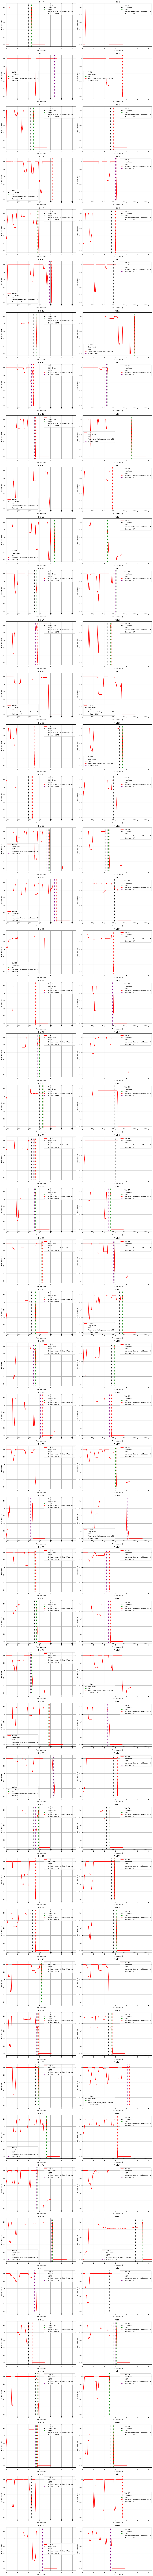

In [18]:
subject = 's027'
condition = 'non_ai'

display_subject_trials(subject, condition, data = shared_control_metrics)